In [1]:
import numpy as np


# set expectations and observation
expBkg = 1000
expSig = 0
obs = 1040

# assume background is perfectly known
sigObs = obs - expBkg
sigErr = obs**0.5

# significance from zero
nsigma = (sigObs/sigErr)

print('Saw', obs, 'events')
print('Expect', expBkg, 'background')
print('Infer nSig =',sigObs,'+/-', sigErr)
print('This is', '{:4.2f}'.format(nsigma), 'sigma from 0')



Saw 1040 events
Expect 1000 background
Infer nSig = 40 +/- 32.2490309931942
This is 1.24 sigma from 0


In [2]:
# now check this with toys

# generate some toys from the background only expectation
np.random.seed(210187)
vals = np.random.poisson(expBkg, size=100000)

# compute the p-value of observation (i.e. fraction of toys which are larger than the observation)
pval = len(vals[vals>=obs]) / len(vals)

# this is the equivalent two-sided p-value
#pval = len(vals[(vals>=obs) | (vals<=obs-2*sigObs)]) / len(vals)

# convert to sigma using chi2 distribution
from scipy.stats import chi2
nsigma_1side = (chi2.ppf(1-2*pval,1))**0.5
nsigma_2side = (chi2.ppf(1-pval,1))**0.5

print('p-value from toys is', pval)
print('1-sided conversion is', '{:4.2f}'.format(nsigma_1side), 'sigma from 0')
print('2-sided conversion is', '{:4.2f}'.format(nsigma_2side), 'sigma from 0')





p-value from toys is 0.10591
1-sided conversion is 1.25 sigma from 0
2-sided conversion is 1.62 sigma from 0


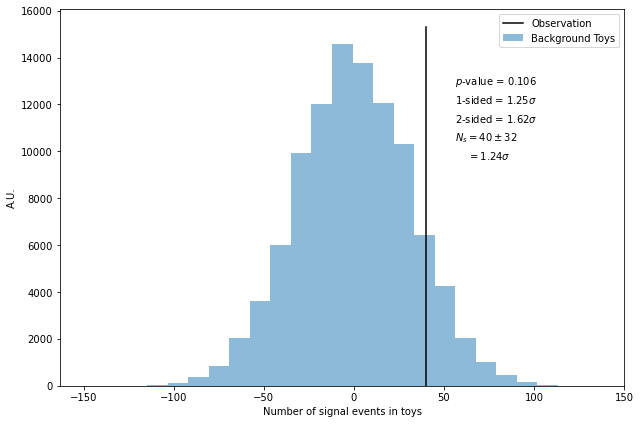

In [3]:
# make a plot
import matplotlib.pyplot as plt
f = plt.figure(figsize=(9,6))
h = plt.hist( vals-expBkg, bins=25, alpha=0.5, label='Background Toys' )
plt.xlabel('Number of signal events in toys')
plt.ylabel('A.U.')
ylim = plt.ylim()
plt.plot((sigObs,sigObs), (0,ylim[1]), 'k-', label='Observation')
plt.text( 0.7, 0.8 ,'$p$-value = {:5.3f}'.format(pval), transform=plt.gca().transAxes)
plt.text( 0.7, 0.75,'1-sided = ${:4.2f}\sigma$'.format(nsigma_1side), transform=plt.gca().transAxes)
plt.text( 0.7, 0.7 ,'2-sided = ${:4.2f}\sigma$'.format(nsigma_2side), transform=plt.gca().transAxes)
plt.text( 0.7, 0.65,'$N_s = {:2.0f} \pm {:2.0f}$'.format(sigObs,sigErr), transform=plt.gca().transAxes)
plt.text( 0.7, 0.6 ,'    $= {:4.2f}\sigma$'.format(nsigma), transform=plt.gca().transAxes)
l = plt.legend()
plt.tight_layout()
plt.savefig('pval.pdf')


┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig │    40     │    32     │    -32     │     33     │  -100   │   200   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Distance from zero from err = 1.25 sigma
DLL at 0 gives 1.26 sigma 


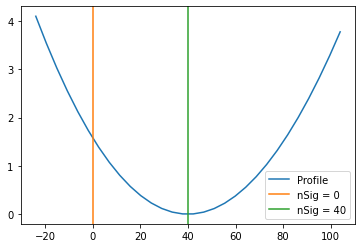

In [4]:
# do it the likelihood way
from scipy.stats import poisson

def nll(nsig):
    return -2*poisson.logpmf(obs,expBkg+nsig)

from iminuit import Minuit

m = Minuit(nll, nsig=40, limit_nsig=(-100,200), pedantic=False)

m.migrad()
m.hesse()
m.minos()

x,y,f = m.mnprofile('nsig',bound=2,subtract_min=True)

print(m.params)
xm = m.values['nsig']
fm = nll(xm)
x0 = 0
f0 = nll(x0)
dll_data = f0-fm

plt.plot(x,y,label='Profile')
ylim = plt.ylim()
plt.plot([x0,x0],ylim, label='nSig = 0')
plt.plot([xm,xm],ylim, label='nSig = 40')
plt.ylim(ylim)
plt.legend()

print('Distance from zero from err = {:1.2f} sigma'.format( (xm-x0)/abs(m.merrors['nsig'].lower)) )
#print('DLL at 0 = ', f0-fm)
print('DLL at 0 gives {:1.2f} sigma '.format( (f0-fm)**0.5 ) )

Text(0.5, 0, 'Number of Signal')

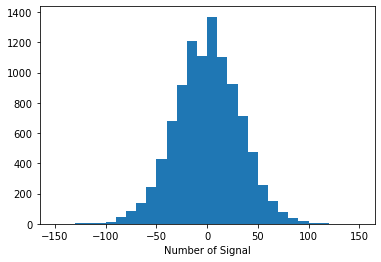

In [5]:
dll_toys = []
ns_toys = []
for val in vals[:10000]:
    tnll = lambda ns: -2*poisson.logpmf(val,expBkg+ns)
    tm = Minuit(tnll, ns=0, limit_ns=(-500,500), pedantic=False)
    tm.migrad()
    dll_toys.append( tnll(0) - tnll(tm.values['ns']) )
    ns_toys.append( tm.values['ns'] )
dll_toys = np.array(dll_toys)
ns_toys = np.array(ns_toys)
x = plt.hist( ns_toys, bins=30, range=(-150,150))
plt.xlabel('Number of Signal')

0.2019
1-sided 0.83 sigma
2-sided 1.28 sigma


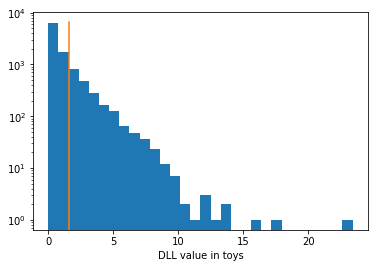

In [6]:
plt.hist(dll_toys,bins=30)
ylim = plt.ylim()
plt.plot( [dll_data,dll_data], [0,ylim[1]] )
plt.yscale('log')
plt.xlabel('DLL value in toys')

nworse = np.sum(dll_toys>dll_data)
ntotal  = len(dll_toys)
pval = nworse / ntotal

# so generating p-value with toys in this way (i.e. where toys are allowed to have both neg and pos sigma)
print(pval)
nsigma_1side = (chi2.ppf(1-2*pval,1))**0.5
nsigma_2side = (chi2.ppf(1-pval,1))**0.5
print('1-sided {:4.2f} sigma'.format(nsigma_1side))
print('2-sided {:4.2f} sigma'.format(nsigma_2side))


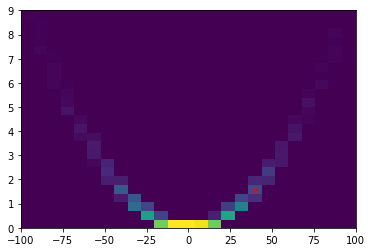

In [7]:
plt.hist2d(ns_toys, dll_toys,bins=(25,25), range=((-100,100),(0,9)))
plt.plot(40, dll_data, 'rx')

Text(0.5, 0, 'Number of Signal')

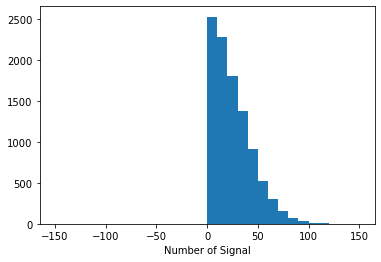

In [8]:
vals = np.array(vals)
dll_toys = []
ns_toys = []
for val in vals[vals>1000][:10000]:
    tnll = lambda ns: -2*poisson.logpmf(val,expBkg+ns)
    tm = Minuit(tnll, ns=0, limit_ns=(-500,500), pedantic=False)
    tm.migrad()
    dll_toys.append( tnll(0) - tnll(tm.values['ns']) )
    ns_toys.append( tm.values['ns'] )
dll_toys = np.array(dll_toys)
ns_toys = np.array(ns_toys)
x = plt.hist( ns_toys, bins=30, range=(-150,150))
plt.xlabel('Number of Signal')

0.2004
1-sided 0.84 sigma
2-sided 1.28 sigma


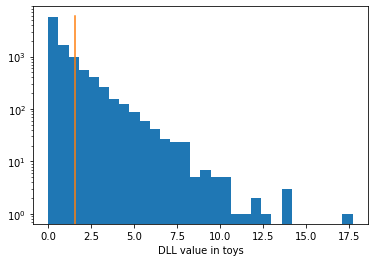

In [9]:
plt.hist(dll_toys,bins=30)
ylim = plt.ylim()
plt.plot( [dll_data,dll_data], [0,ylim[1]] )
plt.yscale('log')
plt.xlabel('DLL value in toys')

nworse = np.sum(dll_toys>dll_data)
ntotal  = len(dll_toys)
pval = nworse / ntotal

# so generating p-value with toys in this way (i.e. where toys are allowed to have both neg and pos sigma)
print(pval)
nsigma_1side = (chi2.ppf(1-2*pval,1))**0.5
nsigma_2side = (chi2.ppf(1-pval,1))**0.5
print('1-sided {:4.2f} sigma'.format(nsigma_1side))
print('2-sided {:4.2f} sigma'.format(nsigma_2side))

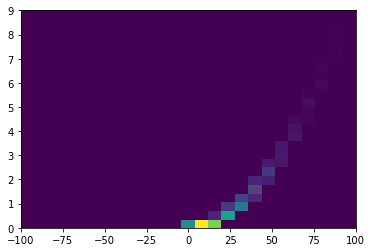

In [10]:
plt.hist2d(ns_toys, dll_toys,bins=(25,25), range=((-100,100),(0,9)))
plt.plot(40, dll_data, 'rx')

Text(0.5, 0, 'Number of Signal')

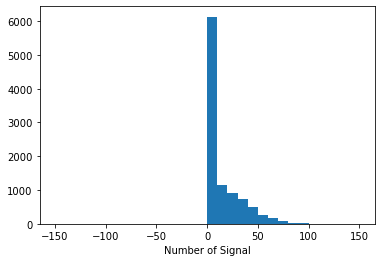

In [11]:
dll_toys = []
ns_toys = []
for val in vals[:10000]:
    tnll = lambda ns: -2*poisson.logpmf(val,expBkg+ns)
    tm = Minuit(tnll, ns=0, limit_ns=(0,500), pedantic=False)
    tm.migrad()
    dll_toys.append( tnll(0) - tnll(tm.values['ns']) )
    ns_toys.append( tm.values['ns'] )
dll_toys = np.array(dll_toys)
ns_toys = np.array(ns_toys)
x = plt.hist( ns_toys, bins=30, range=(-150,150))
plt.xlabel('Number of Signal')

0.1012
1-sided 1.27 sigma
2-sided 1.64 sigma


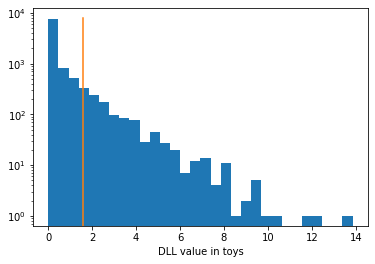

In [12]:
plt.hist(dll_toys,bins=30)
ylim = plt.ylim()
plt.plot( [dll_data,dll_data], [0,ylim[1]] )
plt.yscale('log')
plt.xlabel('DLL value in toys')

nworse = np.sum(dll_toys>dll_data)
ntotal  = len(dll_toys)
pval = nworse / ntotal

# so generating p-value with toys in this way (i.e. where toys are allowed to have both neg and pos sigma)
print(pval)
nsigma_1side = (chi2.ppf(1-2*pval,1))**0.5
nsigma_2side = (chi2.ppf(1-pval,1))**0.5
print('1-sided {:4.2f} sigma'.format(nsigma_1side))
print('2-sided {:4.2f} sigma'.format(nsigma_2side))

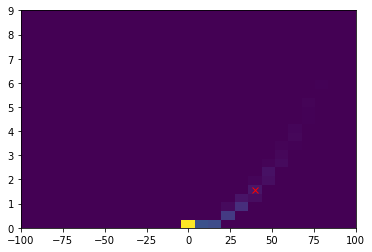

In [13]:
plt.hist2d(ns_toys, dll_toys,bins=(25,25), range=((-100,100),(0,9)))
plt.plot(40, dll_data, 'rx')

Text(0.5, 0, 'Number of Signal')

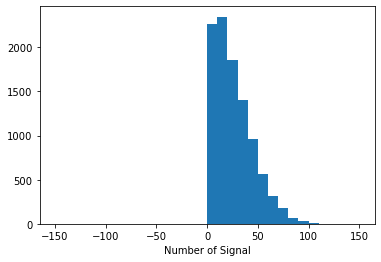

In [14]:
vals = np.array(vals)
dll_toys = []
ns_toys = []
for val in vals[vals>1000][:10000]:
    tnll = lambda ns: -2*poisson.logpmf(val,expBkg+ns)
    tm = Minuit(tnll, ns=0, limit_ns=(0,500), pedantic=False)
    tm.migrad()
    dll_toys.append( tnll(0) - tnll(tm.values['ns']) )
    ns_toys.append( tm.values['ns'] )
dll_toys = np.array(dll_toys)
ns_toys = np.array(ns_toys)
x = plt.hist( ns_toys, bins=30, range=(-150,150))
plt.xlabel('Number of Signal')

0.2004
1-sided 0.84 sigma
2-sided 1.28 sigma


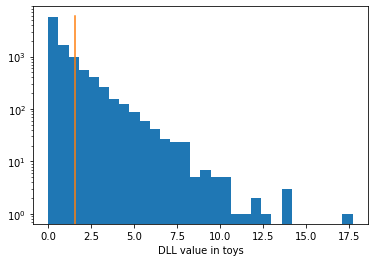

In [15]:
plt.hist(dll_toys,bins=30)
ylim = plt.ylim()
plt.plot( [dll_data,dll_data], [0,ylim[1]] )
plt.yscale('log')
plt.xlabel('DLL value in toys')

nworse = np.sum(dll_toys>dll_data)
ntotal  = len(dll_toys)
pval = nworse / ntotal

# so generating p-value with toys in this way (i.e. where toys are allowed to have both neg and pos sigma)
print(pval)
nsigma_1side = (chi2.ppf(1-2*pval,1))**0.5
nsigma_2side = (chi2.ppf(1-pval,1))**0.5
print('1-sided {:4.2f} sigma'.format(nsigma_1side))
print('2-sided {:4.2f} sigma'.format(nsigma_2side))

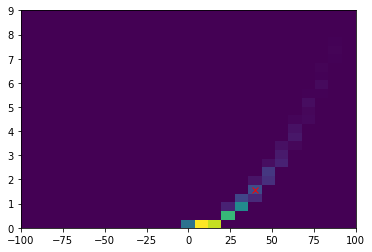

In [16]:
plt.hist2d(ns_toys, dll_toys,bins=(25,25), range=((-100,100),(0,9)))
plt.plot(40, dll_data, 'rx')

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nbkg │    960    │    40     │            │            │         │         │       │
│ 1 │ nsig │    235    │    24     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nbkg │  1.200e3  │  0.035e3  │            │            │         │         │       │
│ 1 │ nsig │     0     │    24     │            │            │         │         │  yes  │

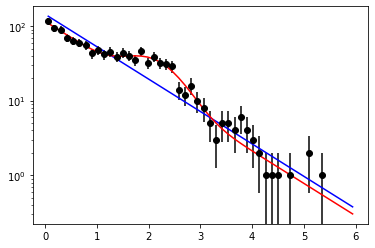

In [17]:
## a chi2 like example
from scipy.stats import expon, norm, chi2

bkg = expon.rvs(size=1000)
sig = norm(2,0.5).rvs(size=200)
data = np.append(bkg,sig)

def nll(nbkg,nsig):
    bpdf = expon()
    spdf = norm(2,0.5)
    return nbkg+nsig - np.sum(np.log(nbkg*bpdf.pdf(data) + nsig*spdf.pdf(data) ) )

def pdf(x, nbkg,nsig):
    bpdf = expon()
    spdf = norm(2,0.5)
    return nbkg*bpdf.pdf(x) + nsig*spdf.pdf(x)

def cchi2( x, xerr, y ):
    return np.sum( (y[xerr>0]-x[xerr>0])**2/xerr[xerr>0]**2 )

m = Minuit(nll, nbkg=1000, nsig=200, pedantic=False, errordef=0.5)
m.migrad()
m.hesse()
print(m.params)
nbf = m.values['nbkg']
nsf = m.values['nsig']
nse = m.errors['nsig']
m.values['nsig'] = 0
m.fixed['nsig'] = True
m.migrad()
m.hesse()
print(m.params)
nbo = m.values['nbkg']

#plt.hist([bkg,sig],stacked=True, bins=50)
bc, xe = np.histogram(data, bins=50, range=(0,6))

cx = xe[:-1] + (xe[1:]-xe[:-1])/2
N = 6/50.

plt.errorbar(cx,bc,bc**0.5,fmt='ko')
plt.plot(cx, N*pdf(cx,nbo,0), 'b-')
plt.plot(cx, N*pdf(cx,nbf,nsf), 'r-')
plt.yscale('log')

chi2b  = cchi2( bc, bc**0.5, N*pdf(cx,nbo,0))
chi2sb = cchi2( bc, bc**0.5, N*pdf(cx,nbf,nsf))
print( 'chi2 (B-only):', chi2b)
print( '        / dof:', chi2b / 49 )
print( '         pval: ', chi2.cdf( chi2b, 49))
print( 'chi2 (S+B)   :', chi2sb)
print( '        / dof:', chi2sb / 48 )
print( '         pval:', chi2.cdf( chi2sb, 48))
print( 'DChi2**0.5:   ', (chi2b - chi2sb)**0.5 )
print( 'Naive d to 0: ', nsf/nse)

